In [66]:
import pandas as pd
import seaborn as sns

def get_strain_data(
    tsv_name, last_index=None,
):
    df = pd.read_csv(tsv_name, sep="\t")
    if last_index is None:
        last_index = len(df) - 1
    strain_values = convert_pixels_to_strain(
        bottom_y_value=df["y_pos"][0], y_pixel_values=df["y_pos"][1:last_index].to_list()
    )
    return strain_values

def convert_pixels_to_strain(bottom_y_value, y_pixel_values):
    top_y_value = y_pixel_values[0]
    original_len = bottom_y_value - top_y_value
    return [((bottom_y_value - y_pixel) / original_len) - 1 for y_pixel in y_pixel_values]

In [67]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt


def piecewise_linear(x, x0, y0, slope):
    return np.piecewise(
        x, [x <= x0, x > x0], [lambda x: slope * (x - x0) + y0, lambda x: y0]
    )


def fit_piecewise_linear(x_data, y_data, initial_guess=None):
    """
    Fit a piecewise linear model to data

    Parameters:
    -----------
    x_data, y_data : array_like
        The data to fit
    initial_guess : list, optional
        Initial guess for [x0, y0, slope]

    Returns:
    --------
    params : list
        Optimal values for [x0, y0, slope]
    """
    # Convert input data to numpy arrays if they aren't already
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)

    # Make an initial guess if not provided
    if initial_guess is None:
        # Estimate where the data flattens
        y_diff = np.abs(np.diff(y_data))
        potential_breakpoint = np.argmin(y_diff) + 1
        x0_guess = float(
            x_data[potential_breakpoint]
        )  # Ensure it's a single float value
        y0_guess = float(
            y_data[potential_breakpoint]
        )  # Ensure it's a single float value

        # Estimate slope from early data (first half of data before breakpoint)
        early_size = max(2, potential_breakpoint // 2)
        x_early = x_data[:early_size]
        y_early = y_data[:early_size]

        if len(x_early) >= 2:
            slope_guess, _ = np.polyfit(x_early, y_early, 1)
        else:
            slope_guess = 0.0

        initial_guess = [x0_guess, y0_guess, slope_guess]

    # Perform the fit
    try:
        params, _ = optimize.curve_fit(
            piecewise_linear, x_data, y_data, p0=initial_guess
        )
    except (RuntimeError, TypeError) as e:
        print(f"Curve fitting failed: {e}")
        print("Using initial guess as parameters")
        params = initial_guess
    print(params)
    return params


def plot_piecewise_fit(x_data, y_data, params, title="Piecewise Linear Fit"):
    """
    Plot the data and the fitted piecewise linear function

    Parameters:
    -----------
    x_data, y_data : array_like
        The data to plot
    params : list
        Parameters [x0, y0, slope] for the piecewise function
    title : str, optional
        Plot title
    """
    x0, y0, slope = params

    # Create a smooth x array for plotting the fitted function
    x_fit = np.linspace(min(x_data), max(x_data), 1000)
    y_fit = piecewise_linear(x_fit, x0, y0, slope)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, color="b", label="Data")
    plt.plot(
        x_fit,
        y_fit,
        "r-",
        label=f"Fitted Function x0({x0:.4g}) y0 ({y0:.4g}) slope ({slope:.4g})",
    )

    # Add vertical line at breakpoint
    plt.axvline(x=x0, color="g", linestyle="--", label=f"Breakpoint (x={x0:.2f})")

    # Add horizontal line for the constant part
    plt.axhline(y=y0, color="k", linestyle=":", label=f"Steady value (y={y0:.2f})")

    plt.xlabel("Time (minutes)")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    plt.show()

    return plt.gcf()

[14.38153    -0.76155718 -0.05372784]


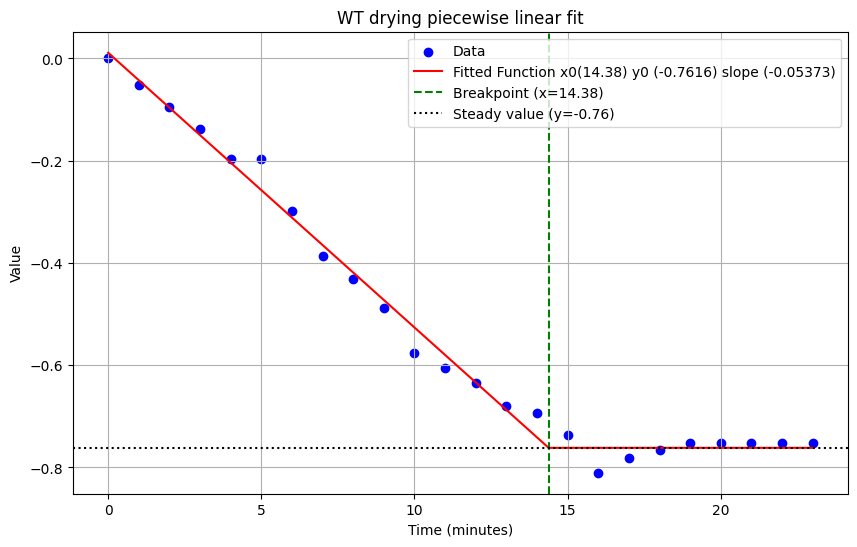

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
drying_data = get_strain_data('drying_data/120C_strain_data_wt.tsv',last_index=25)

minutes = [idx for idx in range(len(drying_data))]
assert(len(minutes) == len(drying_data))
params = fit_piecewise_linear(minutes, drying_data)
x0_fit, y0_fit, slope_fit = params

plot_piecewise_fit(minutes, drying_data, params, "WT 120C drying piecewise linear fit")

[ 1.05555109 -0.12121155 -0.10489566]
1.055551086915206 -0.1212115488827811 -0.10489565986761698


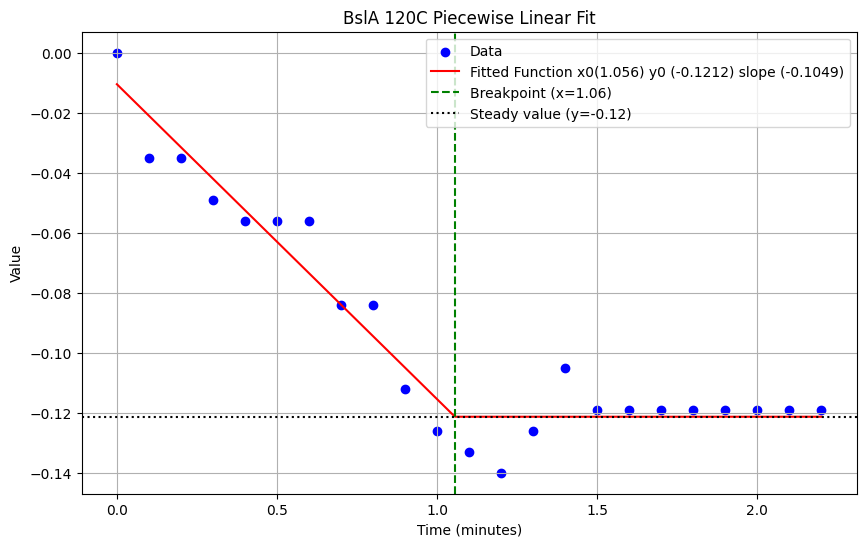

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [69]:
bsla_20_strains = get_strain_data('drying_data/120C_strain_data_bsla.tsv',last_index=None)
# This one was taken at 0.1 second intervals 
minutes = [float(idx / 10) for idx in range(len(bsla_20_strains))]
assert(len(minutes) == len(bsla_20_strains))
params = fit_piecewise_linear(minutes, bsla_20_strains)
x0_fit, y0_fit, slope_fit = params
print(x0_fit, y0_fit, slope_fit)
plot_piecewise_fit(minutes, bsla_20_strains, params, "BslA 120C Piecewise Linear Fit")

# Not so relevant, but we have other data too collected for 20C

[ 6.4736842  -0.16666667 -0.02513228]


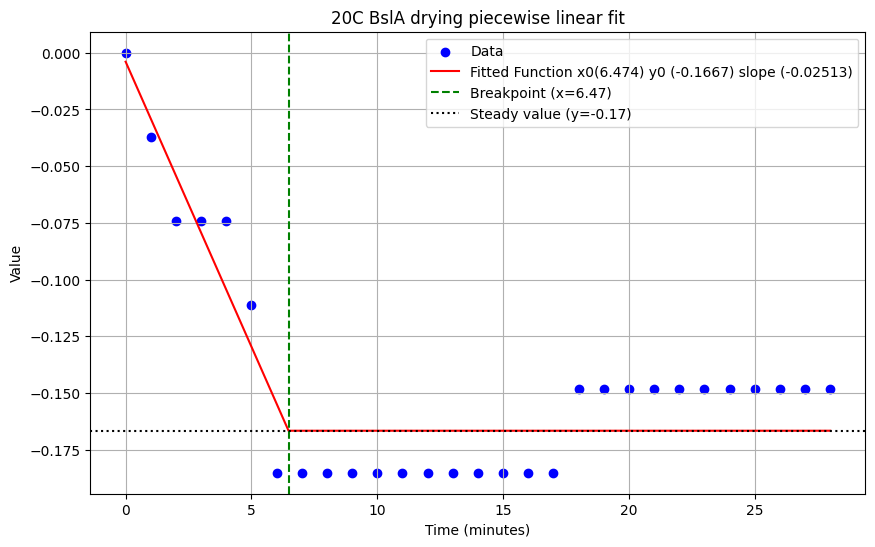

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [70]:
drying_data = get_strain_data('drying_data/20C_strain_data_bsla.tsv',last_index=30)

minutes = [idx for idx in range(len(drying_data))]
assert(len(minutes) == len(drying_data))
params = fit_piecewise_linear(minutes, drying_data)
x0_fit, y0_fit, slope_fit = params

plot_piecewise_fit(minutes, drying_data, params, "20C BslA drying piecewise linear fit")

[ 9.97961755e+01 -6.42742121e-01 -5.99613584e-03]


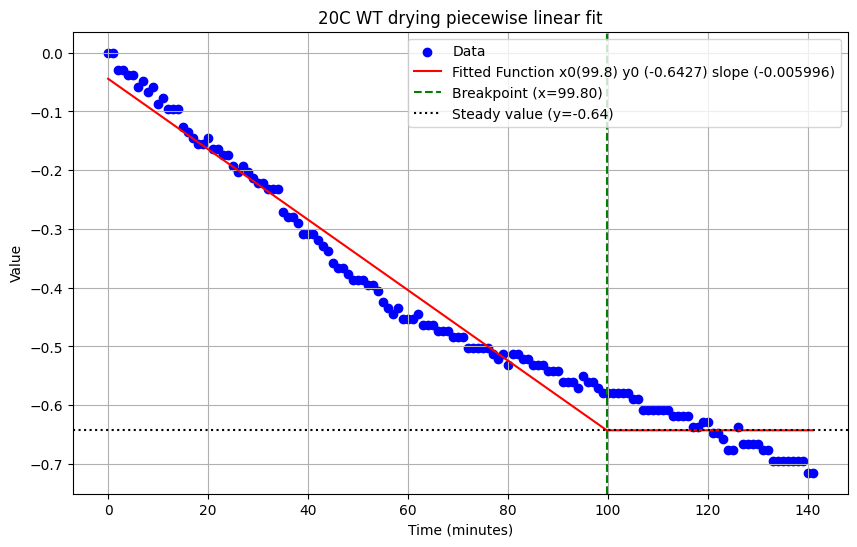

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [71]:
drying_data = get_strain_data('drying_data/20C_strain_data_wt.tsv',last_index=None)

minutes = [idx for idx in range(len(drying_data))]
assert(len(minutes) == len(drying_data))
params = fit_piecewise_linear(minutes, drying_data)
x0_fit, y0_fit, slope_fit = params

plot_piecewise_fit(minutes, drying_data, params, "20C WT drying piecewise linear fit")